In [42]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns
import sweetviz as sv
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
import optuna

In [43]:
data = pd.read_csv('dataset/water_potability.csv')

# EDA

In [44]:
data.head()
# report = sv.analyze(data)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


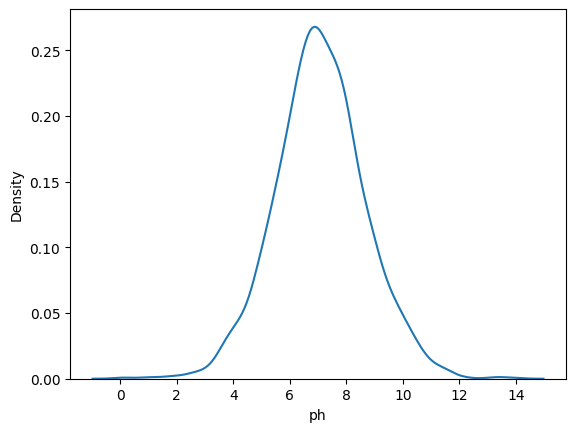

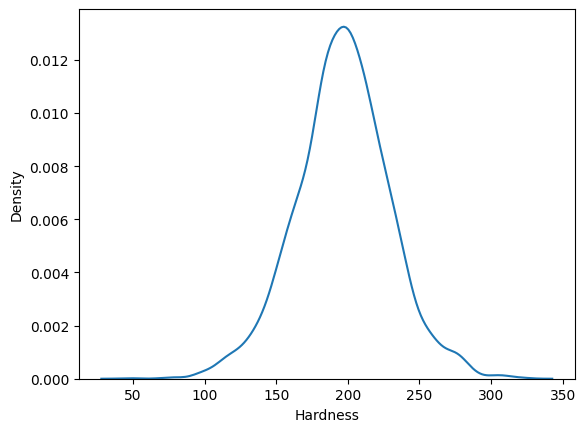

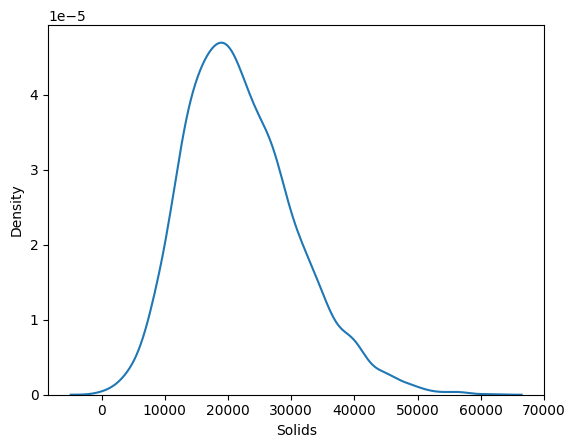

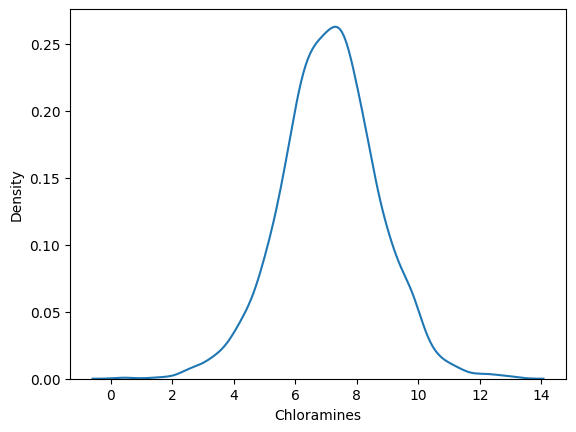

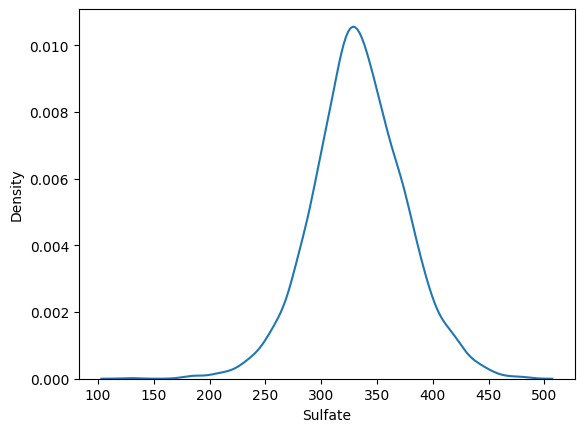

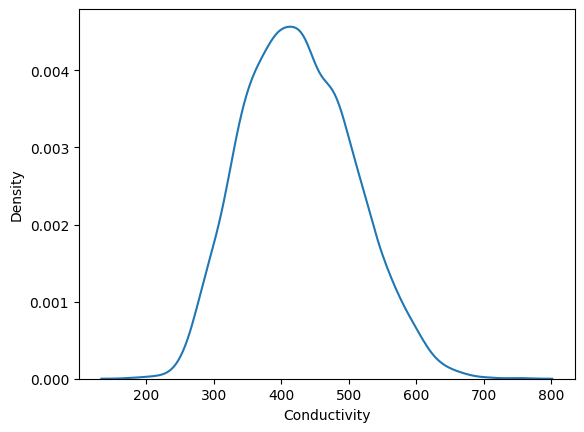

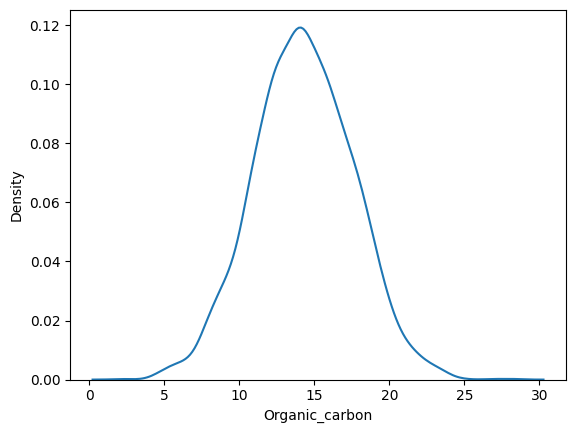

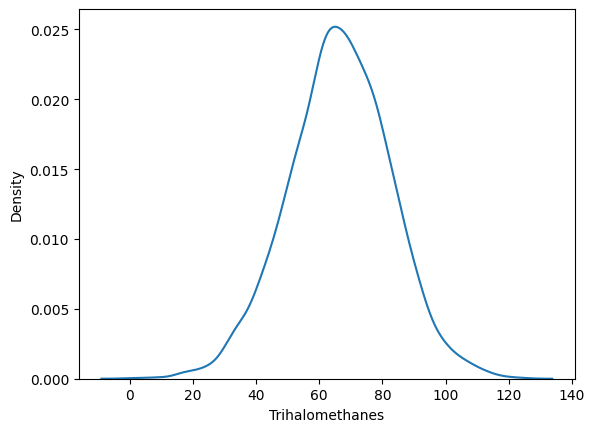

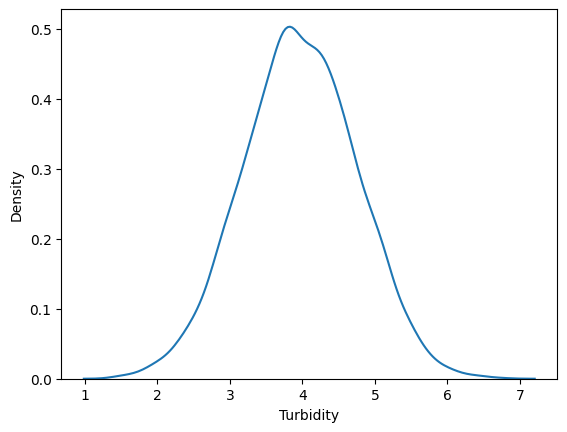

In [45]:
for i in data.columns[:-1] :
    plt.figure()
    sns.kdeplot(data[i])
    plt.show()

In [46]:
data.skew(axis=0, skipna=True)

ph                 0.025630
Hardness          -0.039342
Solids             0.621634
Chloramines       -0.012098
Sulfate           -0.035947
Conductivity       0.264490
Organic_carbon     0.025533
Trihalomethanes   -0.083031
Turbidity         -0.007817
Potability         0.450784
dtype: float64

In [47]:
pt = PowerTransformer()
data_skew = data.copy()
data_skew[['Solids']] = pt.fit_transform(data_skew[['Solids']])
data_skew.skew(axis=0, skipna=True)

ph                 0.025630
Hardness          -0.039342
Solids             0.019888
Chloramines       -0.012098
Sulfate           -0.035947
Conductivity       0.264490
Organic_carbon     0.025533
Trihalomethanes   -0.083031
Turbidity         -0.007817
Potability         0.450784
dtype: float64

In [48]:
data.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Analisis menunjukkan terdapat skewness pada kolom :
- Solids
- Trihalomethanes

In [49]:
def data_generate(df) :
    train, test = train_test_split(df, test_size=0.3, random_state=42)
    return train, test

def train_preproc(train,cols) :
    imputer = KNNImputer(n_neighbors=3)
    pt = PowerTransformer()
    scaler = MinMaxScaler()
    # train = train.dropna()
    train = imputer.fit_transform(train)
    # train = scaler.fit_transform(train)
    train = pd.DataFrame(train, columns=cols)
    train[['Solids']] = pt.fit_transform(train[['Solids']])
    X_train = train[train.columns[:-1]]
    y_train = train[train.columns[-1]]
    
    return X_train, y_train

Imputasi

# Modelling

In [53]:
import math
def lvq_fit(X_train,y_train, a, b, max_ep, e) :
    
    # inisialisasi id untuk weight pertama
    X_train_reset_id = X_train.reset_index(drop=True)
    y_train_reset_id = y_train.reset_index(drop=True)
    c, train_idx = np.unique(y_train, True)
    r = c

    # inisialisasi weight berdasarkan id
    W = X_train_reset_id.iloc[train_idx].values.astype(np.float64)

    # inisialisasi train berdasarkan index
    X_train_reset_id = np.array(X_train_reset_id.iloc[[i for i in X_train_reset_id.index if i not in train_idx]])
    y_train_reset_id = np.array(y_train_reset_id.iloc[[i for i in y_train_reset_id.index if i not in train_idx]])

    ep = 0

    while ep < max_ep :
        for i, x in enumerate(X_train_reset_id) :
            d = [math.sqrt(sum((w - x) **2)) for w in W]
            min_1 = np.argmin(d)
            min_2 = 0
            dc = float(np.amin(d))
            dr = 0
            min_2 = d.index(sorted(d)[1])
            dr = float(d[min_2])
            
            if c[min_1] == y_train_reset_id[i] and c [min_1] != r[min_2] :
                W[min_1] = W[min_1] + a * (x-W[min_1])  
            
            #Implementasi LVQ2.1
            elif c[min_1] != r[min_2] and y_train_reset_id[i] == r[min_2] :
                
                if dc != 0 and dr != 0 :
                    
                    #Implementasi LVQ3
                    if min((dc/dr),(dr/dc)) > (1-e) / (1+e) :
                        
                        W[min_1] = W[min_1] - a * (x - W[min_1])
                        W[min_2] = W[min_2] + a * (x - W[min_2])
            
            #Implementasi LVQ2            
            elif c[min_1] == r[min_2] and y_train_reset_id[i] == r[min_2] :
                
                W[min_1] = W[min_1] + e * a * (x - W[min_1])
                W[min_2] = W[min_2] + e * a * (x - W[min_2])

        a = a * b
        
        ep += 1
    
    return W,c       

def lvq_test(x, W) :
    W, c = W
    d = [math.sqrt(sum((w-x) ** 2)) for w in W]
    return c[np.argmin(d)]
      
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels,
           preds, average = 'weighted')))
    print("Recall Score: {}".format(recall_score(labels, preds,
           average = 'weighted')))
    print("Accuracy Score: {}".format(accuracy_score(labels,
           preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average =
           'weighted')))
    
def objective(trial, X_train, X_test, y_train, y_test) :
    a = trial.suggest_float('a', 0.1,1)
    b = trial.suggest_float('b', 0.01, 0.1)
    max_ep = trial.suggest_int('epoch', 100, 1000)
    e = trial.suggest_float('e', 0.1, 1)
    
    W = lvq_fit(X_train, y_train,
    a = a,
    b = b,
    max_ep = max_ep,
    e = e)
    
    predicted = []
    for i in X_test.values :
        predicted.append(lvq_test(i,W))
        
    precision = precision_score(y_test,predicted, average = 'weighted')
    recall = recall_score(y_test,predicted,average = 'weighted')
    accuracy = accuracy_score(y_test,predicted)
    f1 = f1_score(y_test, predicted, average ='weighted')
    
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    
    return accuracy_score(y_test,predicted)
    
    
def dataset_comparison_func(data, label_encoding,preproc, hypertuning):
    
    if(label_encoding) :
        l_enc = LabelEncoder()
        data[data.columns[-1]] = l_enc.fit_transform(data[data.columns[-1]])
        
    train, test = data_generate(data.copy())
    
    X_train = train[train.columns[:-1]]
    y_train = train[train.columns[-1]]
    
    
    if(preproc) :
        X_train, y_train = train_preproc(train, test.columns)
        

    X_test= test[test.columns[:-1]]
    y_test= test[test.columns[-1]]

    if(hypertuning) :
        partial_objective = partial(objective, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
        study = optuna.create_study(direction='maximize')
        study.optimize(partial_objective, n_trials=100)
        trial = study.best_trial
        
        print('Best Trial: ')
        print('Best Value: ', trial.value)
        print('Best Parameter: ')
        for key, value in trial.params.items():
            print(f'{key}: {value}')
    
    else :
        
        W = lvq_fit(X_train, y_train,
            a = 0.82,
            b = 0.07,
            max_ep = 518,
            e = 0.16)
        
        predicted = []
        for i in X_test.values :
            predicted.append(lvq_test(i,W))
        
        print_metrics(y_test, predicted)


# Dataset Comparison

## Water Potability Dataset

In [51]:
df_water = pd.read_csv('dataset/water_potability.csv')
dataset_comparison_func(df_water, label_encoding=True, preproc=True, hypertuning=True)

[I 2023-11-23 23:45:13,075] A new study created in memory with name: no-name-8453748a-cae1-43c7-8935-a7ffcf29429c


[I 2023-11-23 23:45:17,315] Trial 0 finished with value: 0.5371312309257376 and parameters: {'a': 0.11626488307839465, 'b': 0.05169896040471426, 'epoch': 222, 'e': 0.14163610611181154}. Best is trial 0 with value: 0.5371312309257376.


Accuracy: 0.5371312309257376, Precision: 0.537901886154831, Recall: 0.5371312309257376, F1 Score: 0.5375118455073136


[I 2023-11-23 23:45:31,106] Trial 1 finished with value: 0.4883011190233978 and parameters: {'a': 0.9711517474730537, 'b': 0.02715311978617886, 'epoch': 654, 'e': 0.45973578812121607}. Best is trial 0 with value: 0.5371312309257376.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:45:45,761] Trial 2 finished with value: 0.4883011190233978 and parameters: {'a': 0.17572741415541857, 'b': 0.04710083762540789, 'epoch': 716, 'e': 0.6174523589636686}. Best is trial 0 with value: 0.5371312309257376.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:45:50,931] Trial 3 finished with value: 0.4883011190233978 and parameters: {'a': 0.3608873750377153, 'b': 0.03947666231617651, 'epoch': 243, 'e': 0.995532748831999}. Best is trial 0 with value: 0.5371312309257376.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:45:53,765] Trial 4 finished with value: 0.5544252288911495 and parameters: {'a': 0.5861874293179773, 'b': 0.0911799443050049, 'epoch': 159, 'e': 0.13821499430794143}. Best is trial 4 with value: 0.5544252288911495.


Accuracy: 0.5544252288911495, Precision: 0.5479431182727352, Recall: 0.5544252288911495, F1 Score: 0.5508177943150379


[I 2023-11-23 23:46:02,930] Trial 5 finished with value: 0.4883011190233978 and parameters: {'a': 0.40763021422005885, 'b': 0.039117561839544714, 'epoch': 432, 'e': 0.23821195303581005}. Best is trial 4 with value: 0.5544252288911495.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:46:08,500] Trial 6 finished with value: 0.4893184130213632 and parameters: {'a': 0.7049137087939543, 'b': 0.010405318260752259, 'epoch': 250, 'e': 0.6585417678152964}. Best is trial 4 with value: 0.5544252288911495.


Accuracy: 0.4893184130213632, Precision: 0.5627627179451226, Recall: 0.4893184130213632, F1 Score: 0.48720921577144516


[I 2023-11-23 23:46:26,312] Trial 7 finished with value: 0.4883011190233978 and parameters: {'a': 0.19844671777029496, 'b': 0.013277697625755359, 'epoch': 843, 'e': 0.6240101227500757}. Best is trial 4 with value: 0.5544252288911495.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:46:31,094] Trial 8 finished with value: 0.5544252288911495 and parameters: {'a': 0.2904368792900199, 'b': 0.05207778613537723, 'epoch': 258, 'e': 0.11332851172591263}. Best is trial 4 with value: 0.5544252288911495.


Accuracy: 0.5544252288911495, Precision: 0.5484462565309917, Recall: 0.5544252288911495, F1 Score: 0.5511234299082353


[I 2023-11-23 23:46:46,687] Trial 9 finished with value: 0.5442522889114955 and parameters: {'a': 0.9598814129744473, 'b': 0.046524101689637457, 'epoch': 817, 'e': 0.21065577352251436}. Best is trial 4 with value: 0.5544252288911495.


Accuracy: 0.5442522889114955, Precision: 0.5482877533199728, Recall: 0.5442522889114955, F1 Score: 0.5461331791603613


[I 2023-11-23 23:46:56,219] Trial 10 finished with value: 0.4883011190233978 and parameters: {'a': 0.5810842126143974, 'b': 0.09468010631806018, 'epoch': 435, 'e': 0.3729642026369957}. Best is trial 4 with value: 0.5544252288911495.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:46:58,457] Trial 11 finished with value: 0.5574771108850458 and parameters: {'a': 0.40459300086754, 'b': 0.07361457119048097, 'epoch': 113, 'e': 0.103300123318935}. Best is trial 11 with value: 0.5574771108850458.


Accuracy: 0.5574771108850458, Precision: 0.5492991669186991, Recall: 0.5574771108850458, F1 Score: 0.5527942179522108


[I 2023-11-23 23:47:00,845] Trial 12 finished with value: 0.4883011190233978 and parameters: {'a': 0.5036359907090558, 'b': 0.08194476012583604, 'epoch': 111, 'e': 0.29642966836482104}. Best is trial 11 with value: 0.5574771108850458.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:47:03,012] Trial 13 finished with value: 0.6358087487283826 and parameters: {'a': 0.6341871594438128, 'b': 0.07184561754725068, 'epoch': 109, 'e': 0.10287889476868252}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.6358087487283826, Precision: 0.6191249572272505, Recall: 0.6358087487283826, F1 Score: 0.5318724218170139


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:47:12,533] Trial 14 finished with value: 0.6276703967446592 and parameters: {'a': 0.7239736702269517, 'b': 0.0686856487406859, 'epoch': 499, 'e': 0.10200189557329126}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


[I 2023-11-23 23:47:33,872] Trial 15 finished with value: 0.4883011190233978 and parameters: {'a': 0.7372158086098143, 'b': 0.06732733763730575, 'epoch': 967, 'e': 0.31078961535720534}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:47:45,202] Trial 16 finished with value: 0.4883011190233978 and parameters: {'a': 0.7534032473644201, 'b': 0.06301517174482388, 'epoch': 529, 'e': 0.3872226505371693}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:47:52,194] Trial 17 finished with value: 0.4893184130213632 and parameters: {'a': 0.8544145543873082, 'b': 0.08054761313262752, 'epoch': 393, 'e': 0.21535204214795534}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4893184130213632, Precision: 0.5627627179451226, Recall: 0.4893184130213632, F1 Score: 0.48720921577144516


[I 2023-11-23 23:48:04,539] Trial 18 finished with value: 0.4883011190233978 and parameters: {'a': 0.6534752412386823, 'b': 0.06111286438512746, 'epoch': 573, 'e': 0.23434725116503727}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:48:12,403] Trial 19 finished with value: 0.4883011190233978 and parameters: {'a': 0.8242013911450676, 'b': 0.07349692428618132, 'epoch': 362, 'e': 0.4838033781254992}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:48:24,160] Trial 20 finished with value: 0.4883011190233978 and parameters: {'a': 0.49387517097295835, 'b': 0.0862890231735509, 'epoch': 535, 'e': 0.31137585255658495}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:48:27,121] Trial 21 finished with value: 0.5564598168870803 and parameters: {'a': 0.6228455541856424, 'b': 0.07279198381690039, 'epoch': 153, 'e': 0.10528502103068427}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.5564598168870803, Precision: 0.5454661094155469, Recall: 0.5564598168870803, F1 Score: 0.5499121229330396


[I 2023-11-23 23:48:33,923] Trial 22 finished with value: 0.5513733468972533 and parameters: {'a': 0.5044871831820504, 'b': 0.07293803460402916, 'epoch': 333, 'e': 0.11651234334071378}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.5513733468972533, Precision: 0.5455980902752032, Recall: 0.5513733468972533, F1 Score: 0.5482009906054874


[I 2023-11-23 23:48:40,470] Trial 23 finished with value: 0.4883011190233978 and parameters: {'a': 0.6606719947172182, 'b': 0.05908005172797582, 'epoch': 315, 'e': 0.18378435410718819}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:48:43,272] Trial 24 finished with value: 0.5493387589013224 and parameters: {'a': 0.4367490563352982, 'b': 0.06943425498571197, 'epoch': 144, 'e': 0.1860572872512265}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.5493387589013224, Precision: 0.5505896767428828, Recall: 0.5493387589013224, F1 Score: 0.5499507370973511


[I 2023-11-23 23:48:47,151] Trial 25 finished with value: 0.5544252288911495 and parameters: {'a': 0.5749995225963971, 'b': 0.09627814715396786, 'epoch': 202, 'e': 0.11676545069674628}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.5544252288911495, Precision: 0.5479431182727352, Recall: 0.5544252288911495, F1 Score: 0.5508177943150379


[I 2023-11-23 23:48:57,805] Trial 26 finished with value: 0.4883011190233978 and parameters: {'a': 0.5507818410056737, 'b': 0.08003258671802088, 'epoch': 491, 'e': 0.2710424426735293}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:49:11,438] Trial 27 finished with value: 0.4883011190233978 and parameters: {'a': 0.6779021362487465, 'b': 0.06620575773302224, 'epoch': 643, 'e': 0.2008347528122296}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:49:13,286] Trial 28 finished with value: 0.6276703967446592 and parameters: {'a': 0.7763922489635936, 'b': 0.09960243286162021, 'epoch': 100, 'e': 0.10130485779386236}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


[I 2023-11-23 23:49:18,548] Trial 29 finished with value: 0.590030518819939 and parameters: {'a': 0.7784182646039378, 'b': 0.09763044687089223, 'epoch': 299, 'e': 0.15634094641634716}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.590030518819939, Precision: 0.5675458032251753, Recall: 0.590030518819939, F1 Score: 0.5727281748858547


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:49:22,143] Trial 30 finished with value: 0.6276703967446592 and parameters: {'a': 0.8747754564395503, 'b': 0.09974080213284607, 'epoch': 194, 'e': 0.16873356927291988}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


[I 2023-11-23 23:49:25,675] Trial 31 finished with value: 0.6358087487283826 and parameters: {'a': 0.8676551921624335, 'b': 0.08942488937862132, 'epoch': 193, 'e': 0.16773770283366263}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.6358087487283826, Precision: 0.6117181697120914, Recall: 0.6358087487283826, F1 Score: 0.5437209881453705


[I 2023-11-23 23:49:27,574] Trial 32 finished with value: 0.6042726347914548 and parameters: {'a': 0.7939113507692056, 'b': 0.08829958143133877, 'epoch': 106, 'e': 0.16388171429514348}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.6042726347914548, Precision: 0.5753687981525869, Recall: 0.6042726347914547, F1 Score: 0.5773565998063057


[I 2023-11-23 23:49:31,559] Trial 33 finished with value: 0.4883011190233978 and parameters: {'a': 0.7197210336118445, 'b': 0.08961850475045469, 'epoch': 194, 'e': 0.2515883850644169}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:49:36,377] Trial 34 finished with value: 0.4883011190233978 and parameters: {'a': 0.9082620635471821, 'b': 0.08316260299291553, 'epoch': 281, 'e': 0.16924549045163148}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:49:48,801] Trial 35 finished with value: 0.6052899287894201 and parameters: {'a': 0.7965643769370172, 'b': 0.0946774641188538, 'epoch': 708, 'e': 0.14575788638232606}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.6052899287894201, Precision: 0.5755752110918377, Recall: 0.6052899287894201, F1 Score: 0.576999152280161


[I 2023-11-23 23:49:53,795] Trial 36 finished with value: 0.4883011190233978 and parameters: {'a': 0.7403497354343352, 'b': 0.0916129591724957, 'epoch': 214, 'e': 0.2639042406727695}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:49:56,890] Trial 37 finished with value: 0.4903357070193286 and parameters: {'a': 0.8402992507937722, 'b': 0.08581915675717326, 'epoch': 164, 'e': 0.10011278635872137}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4903357070193286, Precision: 0.5614780201981165, Recall: 0.4903357070193286, F1 Score: 0.48924276860948007


[I 2023-11-23 23:50:01,077] Trial 38 finished with value: 0.4883011190233978 and parameters: {'a': 0.9257899126747925, 'b': 0.07897390196011075, 'epoch': 243, 'e': 0.20979304181136327}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:50:18,862] Trial 39 finished with value: 0.5473041709053916 and parameters: {'a': 0.6889122384566143, 'b': 0.09953581676207754, 'epoch': 994, 'e': 0.1501212022334821}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.5473041709053916, Precision: 0.5465487534961854, Recall: 0.5473041709053916, F1 Score: 0.5469216420186651


[I 2023-11-23 23:50:28,341] Trial 40 finished with value: 0.4883011190233978 and parameters: {'a': 0.9828613943431375, 'b': 0.09102568211104045, 'epoch': 457, 'e': 0.3371089067579764}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:50:31,613] Trial 41 finished with value: 0.6347914547304171 and parameters: {'a': 0.8670939146266968, 'b': 0.09417550571637423, 'epoch': 182, 'e': 0.16035078212918383}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.6347914547304171, Precision: 0.6082505663141173, Recall: 0.6347914547304171, F1 Score: 0.5430721288484341


[I 2023-11-23 23:50:35,007] Trial 42 finished with value: 0.4883011190233978 and parameters: {'a': 0.8914414967812225, 'b': 0.09277072060758937, 'epoch': 156, 'e': 0.23600658561533527}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:50:41,728] Trial 43 finished with value: 0.6073245167853509 and parameters: {'a': 0.7978286734129285, 'b': 0.08582055102211197, 'epoch': 379, 'e': 0.14896696837676918}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.6073245167853509, Precision: 0.5772813330014565, Recall: 0.607324516785351, F1 Score: 0.5780013855712781


[I 2023-11-23 23:50:45,961] Trial 44 finished with value: 0.6144455747711088 and parameters: {'a': 0.8441605685320885, 'b': 0.07784420817790513, 'epoch': 244, 'e': 0.211523252956615}. Best is trial 13 with value: 0.6358087487283826.


Accuracy: 0.6144455747711088, Precision: 0.5789978184462438, Recall: 0.6144455747711088, F1 Score: 0.5729506059000177


[I 2023-11-23 23:50:56,792] Trial 45 finished with value: 0.6408952187182095 and parameters: {'a': 0.9436600404354291, 'b': 0.09610767305988067, 'epoch': 609, 'e': 0.13773816211502624}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.6408952187182095, Precision: 0.6170000435040386, Recall: 0.6408952187182095, F1 Score: 0.5746969288738445


[I 2023-11-23 23:51:10,329] Trial 46 finished with value: 0.4883011190233978 and parameters: {'a': 0.9998340915223469, 'b': 0.0947135256487842, 'epoch': 664, 'e': 0.28057797613237667}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:51:24,571] Trial 47 finished with value: 0.6276703967446592 and parameters: {'a': 0.9401551227891634, 'b': 0.08768360346525224, 'epoch': 797, 'e': 0.18928281838343802}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


[I 2023-11-23 23:51:36,664] Trial 48 finished with value: 0.4883011190233978 and parameters: {'a': 0.9424530561708011, 'b': 0.08384031856780043, 'epoch': 591, 'e': 0.24390609581868983}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:51:49,827] Trial 49 finished with value: 0.6276703967446592 and parameters: {'a': 0.8848695571388497, 'b': 0.07744641930051797, 'epoch': 741, 'e': 0.13238306605975297}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


[I 2023-11-23 23:52:02,586] Trial 50 finished with value: 0.4883011190233978 and parameters: {'a': 0.9611100661660715, 'b': 0.09033857090424552, 'epoch': 611, 'e': 0.34730128577531183}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:52:04,895] Trial 51 finished with value: 0.5503560528992879 and parameters: {'a': 0.7569108380143683, 'b': 0.09999066306726248, 'epoch': 126, 'e': 0.10287560702839232}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5503560528992879, Precision: 0.5458333344842226, Recall: 0.5503560528992879, F1 Score: 0.547920536848933


[I 2023-11-23 23:52:07,854] Trial 52 finished with value: 0.5493387589013224 and parameters: {'a': 0.8223499110091591, 'b': 0.09549727401997264, 'epoch': 172, 'e': 0.12903180915001758}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5493387589013224, Precision: 0.5470789552824631, Recall: 0.5493387589013224, F1 Score: 0.5481653303802536


[I 2023-11-23 23:52:23,157] Trial 53 finished with value: 0.4883011190233978 and parameters: {'a': 0.9079332614372954, 'b': 0.09284324433440436, 'epoch': 913, 'e': 0.18548567237721153}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:52:25,067] Trial 54 finished with value: 0.6276703967446592 and parameters: {'a': 0.8719142957046038, 'b': 0.08373052782371283, 'epoch': 112, 'e': 0.14436930635382994}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


[I 2023-11-23 23:52:30,313] Trial 55 finished with value: 0.4883011190233978 and parameters: {'a': 0.6319315207042512, 'b': 0.09036395237736503, 'epoch': 268, 'e': 0.22393725153921584}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:52:38,772] Trial 56 finished with value: 0.5503560528992879 and parameters: {'a': 0.7291289591802154, 'b': 0.09590592267891462, 'epoch': 494, 'e': 0.13355370091627972}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5503560528992879, Precision: 0.5468436149009461, Recall: 0.5503560528992879, F1 Score: 0.5484943789075376


[I 2023-11-23 23:52:44,742] Trial 57 finished with value: 0.5381485249237029 and parameters: {'a': 0.7691602537080922, 'b': 0.07554070325957968, 'epoch': 334, 'e': 0.10206819277508794}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5381485249237029, Precision: 0.5447648176393629, Recall: 0.5381485249237029, F1 Score: 0.5410992045716921


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:52:47,046] Trial 58 finished with value: 0.6276703967446592 and parameters: {'a': 0.7111173815851681, 'b': 0.05627358566767611, 'epoch': 131, 'e': 0.18236813855000444}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


[I 2023-11-23 23:52:52,036] Trial 59 finished with value: 0.4883011190233978 and parameters: {'a': 0.8630942811868414, 'b': 0.08070881726617071, 'epoch': 233, 'e': 0.2819869481568194}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:53:02,913] Trial 60 finished with value: 0.5452695829094608 and parameters: {'a': 0.8180330979151662, 'b': 0.06896802743534416, 'epoch': 556, 'e': 0.23239683896302604}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5452695829094608, Precision: 0.5535632820467254, Recall: 0.5452695829094608, F1 Score: 0.548830156745588


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:53:06,632] Trial 61 finished with value: 0.6276703967446592 and parameters: {'a': 0.868559971085711, 'b': 0.09870277234117666, 'epoch': 193, 'e': 0.16825936910758346}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:53:10,407] Trial 62 finished with value: 0.6276703967446592 and parameters: {'a': 0.9640823642356413, 'b': 0.09986826865332453, 'epoch': 186, 'e': 0.16537229072055085}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


[I 2023-11-23 23:53:14,561] Trial 63 finished with value: 0.5300101729399797 and parameters: {'a': 0.9233444031452496, 'b': 0.09360071607076187, 'epoch': 224, 'e': 0.13181091706915854}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5300101729399797, Precision: 0.5621971916419426, Recall: 0.5300101729399797, F1 Score: 0.5377998081556709


[I 2023-11-23 23:53:16,586] Trial 64 finished with value: 0.5493387589013224 and parameters: {'a': 0.8410781938471922, 'b': 0.09705568234335053, 'epoch': 105, 'e': 0.21719006840347105}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5493387589013224, Precision: 0.5510894005727124, Recall: 0.5493387589013224, F1 Score: 0.5501876443197291


[I 2023-11-23 23:53:19,347] Trial 65 finished with value: 0.5879959308240081 and parameters: {'a': 0.8916788003409749, 'b': 0.08701080318247749, 'epoch': 148, 'e': 0.2014756928173864}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5879959308240081, Precision: 0.5720934142142877, Recall: 0.5879959308240081, F1 Score: 0.5770764056305517


[I 2023-11-23 23:53:24,942] Trial 66 finished with value: 0.4883011190233978 and parameters: {'a': 0.7492453270248597, 'b': 0.09749967550261315, 'epoch': 287, 'e': 0.10181310342634109}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:53:32,328] Trial 67 finished with value: 0.5971515768056969 and parameters: {'a': 0.7862320564921954, 'b': 0.08941015441224856, 'epoch': 403, 'e': 0.16211374231442546}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5971515768056969, Precision: 0.5727179324259928, Recall: 0.5971515768056969, F1 Score: 0.577030046060022


[I 2023-11-23 23:53:45,258] Trial 68 finished with value: 0.5503560528992879 and parameters: {'a': 0.6947559695320406, 'b': 0.09210397915226334, 'epoch': 683, 'e': 0.13686499506197808}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5503560528992879, Precision: 0.5463389285651149, Recall: 0.5503560528992879, F1 Score: 0.5482098194445234


[I 2023-11-23 23:53:58,133] Trial 69 finished with value: 0.4883011190233978 and parameters: {'a': 0.8141364422937093, 'b': 0.09632645436113525, 'epoch': 630, 'e': 0.25366388463713047}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:54:02,509] Trial 70 finished with value: 0.4883011190233978 and parameters: {'a': 0.7679986186093724, 'b': 0.08296042187169368, 'epoch': 208, 'e': 0.18717935893473941}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:54:05,805] Trial 71 finished with value: 0.5401831129196337 and parameters: {'a': 0.9424662091561362, 'b': 0.08811611900796373, 'epoch': 173, 'e': 0.19842843652575184}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5401831129196337, Precision: 0.5401831129196337, Recall: 0.5401831129196337, F1 Score: 0.5401831129196337


[I 2023-11-23 23:54:20,610] Trial 72 finished with value: 0.5300101729399797 and parameters: {'a': 0.9128076166440332, 'b': 0.09351075594885923, 'epoch': 824, 'e': 0.12112993796644969}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5300101729399797, Precision: 0.5655306876667618, Recall: 0.5300101729399795, F1 Score: 0.5377228143735232


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:54:36,202] Trial 73 finished with value: 0.6276703967446592 and parameters: {'a': 0.8539619917425086, 'b': 0.08858993806834398, 'epoch': 872, 'e': 0.1725094507343922}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


[I 2023-11-23 23:54:50,880] Trial 74 finished with value: 0.5330620549338759 and parameters: {'a': 0.9812863363718332, 'b': 0.08557981200231357, 'epoch': 771, 'e': 0.14664837127917654}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5330620549338759, Precision: 0.5569100315298711, Recall: 0.5330620549338759, F1 Score: 0.5403509149607546


[I 2023-11-23 23:55:08,397] Trial 75 finished with value: 0.5249237029501526 and parameters: {'a': 0.9487910819517971, 'b': 0.09708621521821094, 'epoch': 939, 'e': 0.12261616458021779}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5249237029501526, Precision: 0.558480595862398, Recall: 0.5249237029501526, F1 Score: 0.5327823443940913


[I 2023-11-23 23:55:23,183] Trial 76 finished with value: 0.582909460834181 and parameters: {'a': 0.8900340069242593, 'b': 0.09403626818002188, 'epoch': 781, 'e': 0.19838529758375734}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.582909460834181, Precision: 0.568271491452365, Recall: 0.582909460834181, F1 Score: 0.5732117392477897


[I 2023-11-23 23:55:32,427] Trial 77 finished with value: 0.6317395727365208 and parameters: {'a': 0.9293387075698124, 'b': 0.08174225011064304, 'epoch': 501, 'e': 0.16728431196047736}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.6317395727365208, Precision: 0.6004021949535056, Recall: 0.6317395727365208, F1 Score: 0.5788371642748781


[I 2023-11-23 23:55:42,417] Trial 78 finished with value: 0.4883011190233978 and parameters: {'a': 0.8340812490415552, 'b': 0.0648836755437109, 'epoch': 467, 'e': 0.25997798426298446}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:55:51,865] Trial 79 finished with value: 0.6368260427263479 and parameters: {'a': 0.8083284770421146, 'b': 0.070809363751627, 'epoch': 506, 'e': 0.15883947636186727}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.6368260427263479, Precision: 0.6085054409815346, Recall: 0.6368260427263479, F1 Score: 0.5773662581816946


[I 2023-11-23 23:56:00,924] Trial 80 finished with value: 0.4883011190233978 and parameters: {'a': 0.6725105899882139, 'b': 0.071522684959578, 'epoch': 420, 'e': 0.21979595676937666}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:56:10,243] Trial 81 finished with value: 0.6388606307222787 and parameters: {'a': 0.8094191675296176, 'b': 0.07583671410231005, 'epoch': 511, 'e': 0.15356478317383349}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.6388606307222787, Precision: 0.6123124974385262, Recall: 0.6388606307222787, F1 Score: 0.5779314328283847


[I 2023-11-23 23:56:20,266] Trial 82 finished with value: 0.5442522889114955 and parameters: {'a': 0.8039984295035324, 'b': 0.07044904562879535, 'epoch': 546, 'e': 0.15244948783459122}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5442522889114955, Precision: 0.543237719137455, Recall: 0.5442522889114955, F1 Score: 0.5437364992368715


[I 2023-11-23 23:56:29,339] Trial 83 finished with value: 0.5574771108850458 and parameters: {'a': 0.7275371883496861, 'b': 0.07517083483340271, 'epoch': 510, 'e': 0.11236982456092287}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5574771108850458, Precision: 0.5492991669186991, Recall: 0.5574771108850458, F1 Score: 0.5527942179522108


[I 2023-11-23 23:56:39,532] Trial 84 finished with value: 0.5534079348931842 and parameters: {'a': 0.7735408313122999, 'b': 0.06795550618795959, 'epoch': 570, 'e': 0.12599420928448615}. Best is trial 45 with value: 0.6408952187182095.


Accuracy: 0.5534079348931842, Precision: 0.5471600354360058, Recall: 0.5534079348931842, F1 Score: 0.5499460314615557


[I 2023-11-23 23:56:48,756] Trial 85 finished with value: 0.6449643947100712 and parameters: {'a': 0.8243505856604108, 'b': 0.07254545623257345, 'epoch': 518, 'e': 0.16024785025394755}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.6449643947100712, Precision: 0.6296399191452899, Recall: 0.6449643947100712, F1 Score: 0.5694360894798782


[I 2023-11-23 23:56:57,106] Trial 86 finished with value: 0.5422177009155646 and parameters: {'a': 0.8298748953512888, 'b': 0.07245105287229138, 'epoch': 452, 'e': 0.2344068841738702}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.5422177009155646, Precision: 0.5523158622173069, Recall: 0.5422177009155646, F1 Score: 0.546409300758771


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:57:06,219] Trial 87 finished with value: 0.6276703967446592 and parameters: {'a': 0.908660830724381, 'b': 0.08141447264930228, 'epoch': 511, 'e': 0.16505613511589268}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


[I 2023-11-23 23:57:17,048] Trial 88 finished with value: 0.5320447609359105 and parameters: {'a': 0.8020086863360881, 'b': 0.07572153483457814, 'epoch': 608, 'e': 0.18136958518117208}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.5320447609359105, Precision: 0.5593477539006252, Recall: 0.5320447609359105, F1 Score: 0.5396537167666785


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:57:26,311] Trial 89 finished with value: 0.6276703967446592 and parameters: {'a': 0.8734773368907576, 'b': 0.07820013254490263, 'epoch': 474, 'e': 0.15198984103546126}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


[I 2023-11-23 23:57:38,463] Trial 90 finished with value: 0.4883011190233978 and parameters: {'a': 0.8493567705000986, 'b': 0.07031485072801902, 'epoch': 585, 'e': 0.3079938478552009}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


[I 2023-11-23 23:57:48,009] Trial 91 finished with value: 0.4883011190233978 and parameters: {'a': 0.7452645271985312, 'b': 0.06471477167370374, 'epoch': 528, 'e': 0.12047168485642451}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.4883011190233978, Precision: 0.5619290153324182, Recall: 0.4883011190233978, F1 Score: 0.48603827953496204


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:57:56,093] Trial 92 finished with value: 0.6276703967446592 and parameters: {'a': 0.7881511716971245, 'b': 0.07340110406237665, 'epoch': 437, 'e': 0.14076052081373006}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


[I 2023-11-23 23:58:04,856] Trial 93 finished with value: 0.6185147507629705 and parameters: {'a': 0.8552050236629484, 'b': 0.07932756148579817, 'epoch': 493, 'e': 0.19857575845194148}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.6185147507629705, Precision: 0.582691666306766, Recall: 0.6185147507629705, F1 Score: 0.5730299999297092


[I 2023-11-23 23:58:14,383] Trial 94 finished with value: 0.5574771108850458 and parameters: {'a': 0.7145619244866226, 'b': 0.06860437732649764, 'epoch': 525, 'e': 0.1149340102573465}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.5574771108850458, Precision: 0.5498006791707414, Recall: 0.5574771108850458, F1 Score: 0.5531145851914935


[I 2023-11-23 23:58:25,231] Trial 95 finished with value: 0.5442522889114955 and parameters: {'a': 0.821520732121779, 'b': 0.07650787648515808, 'epoch': 556, 'e': 0.17185842031076723}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.5442522889114955, Precision: 0.5427292599118129, Recall: 0.5442522889114955, F1 Score: 0.5434716493370504


[I 2023-11-23 23:58:27,676] Trial 96 finished with value: 0.5859613428280773 and parameters: {'a': 0.7642871441920195, 'b': 0.07469604877931643, 'epoch': 130, 'e': 0.14352579059087947}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.5859613428280773, Precision: 0.5676387288473497, Recall: 0.5859613428280773, F1 Score: 0.572954938444453


[I 2023-11-23 23:58:39,271] Trial 97 finished with value: 0.62970498474059 and parameters: {'a': 0.9271459974285595, 'b': 0.08020965984569967, 'epoch': 614, 'e': 0.21933761317904094}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.62970498474059, Precision: 0.6127991509628672, Recall: 0.62970498474059, F1 Score: 0.497586311260075


/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-23 23:58:51,587] Trial 98 finished with value: 0.6276703967446592 and parameters: {'a': 0.9313995882661665, 'b': 0.0807183157989983, 'epoch': 663, 'e': 0.22790213294430817}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.6276703967446592, Precision: 0.3939701269495979, Recall: 0.6276703967446592, F1 Score: 0.4840907934893184


[I 2023-11-23 23:59:03,084] Trial 99 finished with value: 0.5198372329603256 and parameters: {'a': 0.9023150312117082, 'b': 0.07740430780949291, 'epoch': 614, 'e': 0.210578625826234}. Best is trial 85 with value: 0.6449643947100712.


Accuracy: 0.5198372329603256, Precision: 0.5575143311181264, Recall: 0.5198372329603256, F1 Score: 0.5275854922650752
Best Trial: 
Best Value:  0.6449643947100712
Best Parameter: 
a: 0.8243505856604108
b: 0.07254545623257345
epoch: 518
e: 0.16024785025394755


## Iris Dataset

In [54]:
df_iris = pd.read_csv('dataset/iris.csv')
dataset_comparison_func(df_iris, label_encoding=True, preproc=False, hypertuning=False)

Precision Score: 0.9458333333333333
Recall Score: 0.9333333333333333
Accuracy Score: 0.9333333333333333
F1 Score: 0.9324337831084458


In [ ]:
df_nba = pd.read_csv('dataset/nba_games_2018-2022.csv')
df_nba.drop(df_nba.select_dtypes(include='object'), inplace=True, axis=1)

In [ ]:
df_nba.isna().sum()

Unnamed: 0      0
mp              0
mp.1            0
fg              0
fga             0
               ..
drtg_max_opp    0
total_opp       0
home_opp        0
season          0
won             0
Length: 148, dtype: int64

In [ ]:
dataset_comparison_func(df_nba, label_encoding=False, preproc=False, hypertuning=False)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

/home/FirH/nice/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
